# Example of inference to classify X-ray images in different pathologies

In [2]:
import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import skimage

# AI framework
import torch
from torchvision import transforms

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {DEVICE}')

Device: cuda


### Preprocess the image

In [3]:
def normalize(image, rangeValues = (0, 1), dtype = np.float32):
    """
    Scales intensity values in the image to be within a specific range.

    :param image: input array
    :param rangeValue: minimum and maximum values defining the desired output range
    :param dtype: type of data for intensity value

    :return normalized image
    """
    image = np.array(image)
    image_norm = (image - np.min(image))/(np.max(image) - np.min(image)) # scale between zero and one
    image_norm = image_norm * (rangeValues[1] - rangeValues[0]) + rangeValues[0]
    return image_norm.astype(dtype)

def equalize(image):    
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(image)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)) # MORPH_ELLIPSE
    eq_img = cv2.equalizeHist(image)
    tophat = cv2.morphologyEx(eq_img, cv2.MORPH_TOPHAT, kernel)
    bothat = cv2.morphologyEx(eq_img, cv2.MORPH_BLACKHAT, kernel)
    hat_img = eq_img + tophat - bothat

    return np.dstack((image, clahe_img, hat_img))

In [4]:
image_transform = transforms.Compose([
                            transforms.Resize((512,512)),
                            transforms.ToTensor()
                            ])

### Load an image and apply transforms

In [5]:
# Image path
img_path = "C:/Users/maria/OneDrive/Documentos/Escritorio/CodeChestXRay/TrainXray/Data/PadChest512_PA_Manually_Filtered/82859175795028615596104476143331782913_h8uaaf.png"

# Step 1: Load the image
image_original = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_norm = normalize(image_original, rangeValues = (0, 255), dtype = np.uint8)

# Step 2: Equalize
image_eq = equalize(img_norm)
image_eq = image_eq[...,::-1] # Invert the order of the channels

# Step 3: Resize and transform to tensor   
img_trans = image_transform(Image.fromarray(image_eq)).unsqueeze(0).to(DEVICE)

### Run the inference

In [6]:
def load_and_predict(model_directory, model_names, image):
    
    for model_name, model_file in model_names.items():
        
        # model path
        model_path = os.path.join(model_directory, model_file)

        # Load the model
        model = torch.load(model_path, map_location=torch.device(DEVICE))
        model.to(DEVICE)
        model.eval()
        
        # Forward
        outputs = model(image)

        # Obtain the probabilities
        score = torch.sigmoid(outputs)

        # Use a threshold of 0.5 
        preds = score > 0.5
        
        # Probability of positive 
        probability = score.item() * 100

        # Example code to display the prediction and probability
        if preds:
            prediction = "positive"
        else:
            prediction = "negative"

        print(f"Model {model_name} predicts the image as {prediction}. Probability: {probability:.2f}%")

In [9]:
# Base directory of the models
model_directory = 'models'

# List of model file names
model_names = {
    'infiltations': 'resnet18_infiltration.pth',
    'atelectasis': 'resnet50_atelectasis.pth',
    'mass': 'resnet18_mass.pth',
    'cavitation': 'resnet18_cavitation.pth',
    'rib fracture': 'resnet50_fracture.pth',
    'cardiomegaly': 'resnet18_cardiomegaly.pth',
    'heart insufficiency': 'resnet18_heart_insufficiency.pth',
    'pleural effusion': 'resnet18_pleural_effusion.pth',
    'pneumothorax': 'resnet18_pneumothorax.pth',
    'nodule':'googlenet_nodule.pth',
    'fracture': 'resnet50_fracture.pth',
    'abnormal': 'resnet18_normal.pth'
}

# Call the function to load and predict using the models
load_and_predict(model_directory, model_names,img_trans )

Model infiltations predicts the image as negative. Probability: 4.05%
Model atelectasis predicts the image as negative. Probability: 28.26%
Model mass predicts the image as negative. Probability: 13.24%
Model cavitation predicts the image as negative. Probability: 0.22%
Model rib fracture predicts the image as negative. Probability: 0.21%
Model cardiomegaly predicts the image as positive. Probability: 91.54%
Model heart insufficiency predicts the image as negative. Probability: 10.50%
Model pleural effusion predicts the image as negative. Probability: 1.50%
Model pneumothorax predicts the image as negative. Probability: 2.37%
Model nodule predicts the image as negative. Probability: 0.62%
Model fracture predicts the image as negative. Probability: 0.21%
Model abnormal predicts the image as positive. Probability: 68.20%


# Obtain the heatmap for cardiomegaly

In [10]:
# Base directory of the models
model_directory = 'models'

# Model file name for cardiomegaly
model_name = 'resnet18_cardiomegaly.pth'

# Load the cardiomegaly model
model_path = os.path.join(model_directory, model_name)
model = torch.load(model_path)

target = 0

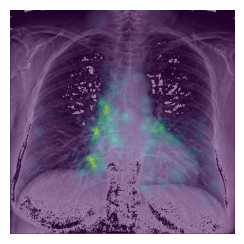

In [11]:
img = img_trans.requires_grad_()

outputs = model(img)
grads = torch.autograd.grad(outputs[:,target], img)[0][0][0]
blurred = skimage.filters.gaussian(grads.detach().cpu().numpy()**2, sigma=(5, 5), truncate=3.5)

my_dpi = 100
fig = plt.figure(frameon=False, figsize=(224/my_dpi, 224/my_dpi), dpi=my_dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img[0][0].detach().cpu().numpy(), cmap="gray", aspect='auto')
ax.imshow(blurred, alpha=0.5);